In [761]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt 
import math
from geopy import distance as geo


In [762]:
parse_dates = lambda x: dt.datetime.strftime(x, "%Y%M%D%H")

# import the df, zipcode and the weather data 
df = pd.read_csv(r"..\output_data\transform_DF", index_col=0)

weather = pd.read_csv(r"\..\data\frankfurt_weather_data2019.csv", sep=",", index_col=0)
zc = pd.read_csv(r"..\geo_Data\backup_zipcodes.csv", index_col=0)

In [766]:
# Take the basic df 
X_predictors = df 

# Create the predictor matrix columns that are not needed
# Create the predictor matrix columns that are not needed
X_predictors = X_predictors.drop(columns=["Start_Latitude"
        , "Bike_number"
        , "Start_Longitude"
        , "End_Station_number"
        , "End_time"
        , "End_Latitude"
        , "End_Longitude"
        , "Bikes_on_position"
        , "End_Bikes", "Start_Station"])

X_predictors["week"] = pd.to_datetime(df["Start_Time"]).dt.strftime('%w').astype(int)  
X_predictors["week_day"] = pd.to_datetime(df["Start_Time"]).dt.strftime('%u').astype(int)                    

In [769]:
# Format date to other format "2019-20-01 00:00:00 to 2019200100"
X_predictors["date"] = X_predictors["Start_Time"].astype(str).str.replace("-","")
X_predictors["date"] = X_predictors["date"].str.replace(":*:.*","")
X_predictors["date"] = X_predictors["date"].str.replace("\s","")

# Create intervalls for hours
X_predictors["hour"] = X_predictors["date"].astype(str).str.extract("([0-9]{2}$)")
X_predictors["month"] = X_predictors["date"].str.replace("([0-9]{4}$)","")

# create month feature  
X_predictors["month"] = X_predictors["month"].astype(str).str.extract("([0-9]{2}$)")

X_predictors["EVENING"] = ((X_predictors["hour"] > "18") | (X_predictors["hour"] == "00"))
X_predictors["MIDDAY"] = ((X_predictors["hour"] > "12") & (X_predictors["hour"] <= "18"))
X_predictors["MORNING"] = ((X_predictors["hour"] > "06") & (X_predictors["hour"] <= "12"))
X_predictors["NIGHT"] = ((X_predictors["hour"] > "00") & (X_predictors["hour"] < "07"))

X_predictors["EVENING"] = pd.to_numeric(X_predictors["EVENING"]).astype(int)
X_predictors["MIDDAY"] = pd.to_numeric(X_predictors["MIDDAY"]).astype(int)
X_predictors["MORNING"] = pd.to_numeric(X_predictors["MORNING"]).astype(int)
X_predictors["NIGHT"] = pd.to_numeric(X_predictors["NIGHT"]).astype(int)

In [739]:
# calculate durantion between center point of downtown and not used in model
down_town = pd.DataFrame(data=[["point A", 8.683319091796875, 50.110285930959314]],
                                columns=["Describtion", "long", "latitude"])
distance_DT = pd.Series(index=df.index, data=list(map(
        lambda x: geo.distance(tuple(down_town.loc[0]["long":"latitude"]),
                               tuple((df.loc[x]["Start_Longitude"], df.loc[x]["Start_Latitude"]))).km, df.index)))
X_predictors["Distan_DT"] = distance_DT    

In [773]:
    # create average hourly duration 
    # format date for hour
    X_predictors["Start_Time_tem"] = pd.to_datetime(X_predictors["date"], format=("%Y%m%d%H"))
    X_predictors["Duration"] = X_predictors["Duration"].astype(float)
    hours = X_predictors.groupby("Start_Time_tem")["Duration"].mean()
    hours = pd.DataFrame(hours)
    count = 0
    hours

,Duration
Start_Time_tem,
2019-01-20 00:00:00,21.666667
2019-01-20 03:00:00,12.000000
2019-01-20 08:00:00,25.000000
2019-01-20 09:00:00,17.000000
2019-01-20 10:00:00,26.000000
...,...
2019-12-31 17:00:00,10.333333
2019-12-31 18:00:00,12.000000
2019-12-31 19:00:00,16.166667


In [ ]:



   
    
 


    
   

    



   



    

    

    # Set target to Y (durations)
    Y = pd.DataFrame(columns=["Duration"], data=X_predictors["Duration"])

    # Drop duration from predictor
    X_predictors.drop(
        columns=["month", "Start_Time", "Duration", "hour", "date", "Zip_codes", "Start_Time_tem"],
        inplace=True)

    df = df.round(3)
 

    X_predictors.fillna(value=0, inplace=True)
    print(X_predictors)
    return X_predictors, Y


In [774]:
count = 0
# create the hourly averages of the last 4 hours before booking
for i in X_predictors.index:
        
        try:
            count+=1
            X_predictors.loc[i,"H1"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=1)]["Duration"]
          
        except KeyError :
             continue
            
        try:
            X_predictors.loc[i,"H2"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=2)]["Duration"]
         
        except KeyError :
             continue
        try:
            X_predictors.loc[i,"H3"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=3)]["Duration"]
         
           
        except KeyError :
            continue
        try:
            X_predictors.loc[i,"H4"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=4)]["Duration"]
        except KeyError :
            continue
           
       

In [779]:
# Use zip code for border districts
X_predictors["Borderdistrict"] = X_predictors["Zip_codes"].isin([65929, 60529, 60549, 65931, 65936, 60528, 60388, 60437, 60438, 60439,
                                                 60433, 60598, 60599, 63067, 60314, 60386]).astype(int)

In [780]:
# set temp to datetype string
weather.index = weather.index.astype(str)

#Join weather dates to predictor matrix 
X_predictors = X_predictors.join(weather, on="date" ,how="inner")

# Set weekday from boolean to int 
X_predictors["Weekday"] = X_predictors["Weekday"].astype(int)

# drop not needed weather data 
X_predictors.drop(columns=["relative humidity","Rainfall","SD_SO","V_VV"], inplace=True)


In [781]:
# create the dates for all days in data set 
start = dt.datetime(2019,1,20)
dates = pd.date_range(start=start, end=dt.datetime(2019,6,30), periods=162)
start = dt.datetime(2019,8,1)
dates2 = pd.date_range(start=start, end=dt.datetime(2019,12,31), periods=153)
dates = dates.append(dates2) 
dates

# set series 
median = pd.Series(index = dates, data = 0)
mean = pd.Series(index = dates, data = 0)


count = 0
for i in range(0,315):
    start = dates[count]
    
    if i == 314:
        #median.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= dates[314])]["Duration"].describe()[4]
        mean.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= dates[314])]["Duration"].describe()[1] 
        
        
        break;
    
    end = dates[count+1]
    #median.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= start) & (pd.to_datetime(df["Start_Time"]) < end)]["Duration"].describe()[4]
    mean.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= start) & (pd.to_datetime(df["Start_Time"]) < end)]["Duration"].describe()[1]               
    count+=1    



In [782]:
# set values of average duration for last 4 days 
X_predictors["L1"] = pd.Series(index = df.index,data =list(map(lambda x :  mean.shift(1)[pd.to_datetime(pd.to_datetime(df.loc[x]["Start_Time"]).strftime("%Y-%m-%d"))], df.index)))
X_predictors["L2"] = pd.Series(index = df.index,data =list(map(lambda x :  mean.shift(2)[pd.to_datetime(pd.to_datetime(df.loc[x]["Start_Time"]).strftime("%Y-%m-%d"))], df.index)))


In [787]:
    # Set target to Y (durations)
    Y = pd.DataFrame(columns=["Duration"], data=X_predictors["Duration"])

    # Drop duration from predictor
    X_predictors.drop(
        columns=["week_day","month", "Start_Time", "Duration", "hour", "date", "Zip_codes", "Start_Time_tem", "week", "date", "Start_Time_tem"],
        inplace=True)

    df = df.round(3)
 

    X_predictors.fillna(value=0, inplace=True)
    X_predictors.corr()

,Weekday,EVENING,MIDDAY,MORNING,NIGHT,H1,H2,H3,H4,Borderdistrict,hourly temperatur,L1,L2
Weekday,1.000000,-0.028212,-0.032293,0.014824,0.065292,-0.162417,-0.179677,-0.186999,-0.183973,-0.047175,-0.154301,-0.113648,0.017528
EVENING,-0.028212,1.000000,-0.378652,-0.299255,-0.146580,-0.135277,-0.048749,0.026258,0.086079,-0.030304,-0.074034,-0.011953,-0.026483
MIDDAY,-0.032293,-0.378652,1.000000,-0.579880,-0.284034,0.131462,0.213869,0.299806,0.379682,0.013864,0.249779,0.025638,0.003501
MORNING,0.014824,-0.299255,-0.579880,1.000000,-0.224477,0.088563,0.015890,-0.087498,-0.225464,0.010947,-0.106442,-0.016979,0.000190
NIGHT,0.065292,-0.146580,-0.284034,-0.224477,1.000000,-0.187586,-0.318050,-0.392364,-0.384125,-0.002427,-0.156046,-0.001222,0.026696
H1,-0.162417,-0.135277,0.131462,0.088563,-0.187586,1.000000,0.343323,0.300843,0.261017,0.024415,0.291591,0.209285,0.150535
H2,-0.179677,-0.048749,0.213869,0.015890,-0.318050,0.343323,1.000000,0.428223,0.394898,0.027455,0.332240,0.188603,0.152722
H3,-0.186999,0.026258,0.299806,-0.087498,-0.392364,0.300843,0.428223,1.000000,0.522632,0.023117,0.366232,0.163759,0.117542
H4,-0.183973,0.086079,0.379682,-0.225464,-0.384125,0.261017,0.394898,0.522632,1.000000,0.020738,0.378447,0.153091,0.104227
Borderdistrict,-0.047175,-0.030304,0.013864,0.010947,-0.002427,0.024415,0.027455,0.023117,0.020738,1.000000,0.072623,0.025885,0.019050


In [788]:
X_predictors.fillna(value=0, inplace=True)

X_predictors["L1"] = X_predictors["L1"].round(3)
X_predictors["L2"] = X_predictors["L2"].round(3)
X_predictors["H1"] = X_predictors["H1"].round(3)
X_predictors["H2"] = X_predictors["H2"].round(3)
X_predictors["H3"] = X_predictors["H3"].round(3)
X_predictors["H4"] = X_predictors["H4"].round(3)
temp = X_predictors
X_predictors

,Weekday,EVENING,MIDDAY,MORNING,NIGHT,H1,H2,H3,H4,Borderdistrict,hourly temperatur,L1,L2
13,1,0,1,0,0,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
19571,1,0,1,0,0,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
28319,1,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
39943,1,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
52183,1,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152507,1,0,0,1,0,0.000,0.0,0.000,0.000,0,-3.2,22.100,0.000
153342,1,0,0,1,0,9.500,11.5,0.000,0.000,0,8.2,15.556,22.299
153360,1,0,0,0,1,0.000,0.0,0.000,0.000,0,0.9,19.205,21.171
153682,1,1,0,0,0,15.000,0.0,0.000,0.000,0,13.6,32.891,29.786


In [789]:
# save predictors and target data 
Y.to_csv("Y_target_vector.csv")
X_predictors.to_csv("X_predictor_matrix.csv")

# Linear regression

In [565]:
temp.drop(columns=[ "day_of_year","L2"], inplace= True)
print(Y)
temp.corr()

        Duration
13         100.0
19571       97.0
28319       26.0
39943       11.0
52183       22.0
...          ...
152507       9.0
153342      10.0
153360      23.0
153682       6.0
154273       9.0

[51393 rows x 1 columns]


,Weekday,H1,H2,H3,H4,hourly temperatur,L1,week,target
Weekday,1.000000,-0.162416,-0.179677,-0.186999,-0.183973,-0.154301,-0.113642,0.060013,-0.076746
H1,-0.162416,1.000000,0.343323,0.300843,0.261016,0.291591,0.209283,-0.194125,0.126031
H2,-0.179677,0.343323,1.000000,0.428223,0.394898,0.332241,0.188602,-0.174072,0.105075
H3,-0.186999,0.300843,0.428223,1.000000,0.522632,0.366232,0.163759,-0.139306,0.086802
H4,-0.183973,0.261016,0.394898,0.522632,1.000000,0.378447,0.153089,-0.120396,0.070147
hourly temperatur,-0.154301,0.291591,0.332241,0.366232,0.378447,1.000000,0.410219,-0.083058,0.114227
L1,-0.113642,0.209283,0.188602,0.163759,0.153089,0.410219,1.000000,-0.426931,0.099629
week,0.060013,-0.194125,-0.174072,-0.139306,-0.120396,-0.083058,-0.426931,1.000000,-0.097015
target,-0.076746,0.126031,0.105075,0.086802,0.070147,0.114227,0.099629,-0.097015,1.000000


RMSE:  21.419428748692873
MAE:  12.82631878977882
r²:  0.05218652455748407


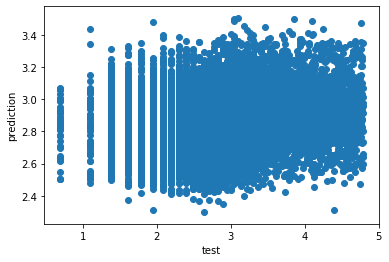

In [806]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X_predictors,Y.apply(np.log) , test_size=0.3)

st_scaler = StandardScaler()


st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)





lin = LinearRegression()
lin.fit(X_train_scaled, y_train)
X_test_scaled = st_scaler.transform(X_test)

X_test_scaled = st_scaler.transform(X_test)
y_predict = lin.predict(X_test_scaled)

plt.scatter(y_test, y_predict)
plt.xlabel("test")
plt.ylabel("prediction")
print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_predict))))
print("MAE: ", metrics.mean_absolute_error(np.exp(y_test), np.exp(y_predict)))
print("r²: ", metrics.r2_score(y_test, y_predict))


In [798]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [793]:
X_train, X_test, y_train, y_test = train_test_split(X_predictors, Y, test_size = 0.2)
st_scaler = StandardScaler()


st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)




In [701]:
rs = RobustScaler()
poly = PolynomialFeatures()
lasso = Lasso()

pipe = Pipeline([
    ("poly", poly),
    ("robust", rs),
    ("lasso", lasso)
])

# Use estimator's give name with a double underscore to set parameters!
param_grid = {
    'poly__degree': [1,2],
    'lasso__alpha': np.linspace(0, 1, 5), # 0.0, 0.25, 0.5, 0.75, 1
}

In [702]:
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=True, n_jobs=4,
                    scoring="neg_root_mean_squared_error")

In [570]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished
C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\sklearn\pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('robust',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                     

In [562]:
grid_df = pd.DataFrame(grid.cv_results_["params"])
grid_df["loss"] = -grid.cv_results_['mean_test_score']
grid_df


y_pred = grid.predict(X_test)

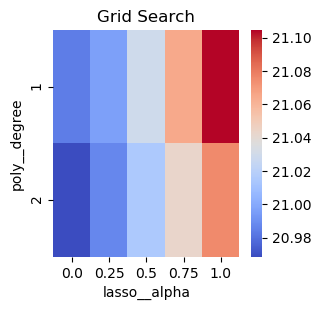

RMSE:  21.103513029249335
MAE:  14.346470298569585
r²:  0.03531014469323657


In [563]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
sns.heatmap(grid_df.pivot(columns="lasso__alpha", values="loss", index="poly__degree"), cmap="coolwarm", ax=ax)
ax.set_title("Grid Search")

plt.show()
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("r²: ", metrics.r2_score(y_test, y_pred))

# --------------------------------------------------------------

In [289]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = lin.predict(X_test_scaled)



print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_predict))))
print("MAE: ", metrics.mean_absolute_error(np.exp(y_test), np.exp(y_predict)))
print("r²: ", metrics.r2_score(y_test,y_predict))

RMSE:  21.912639997347565
MAE:  13.026525713297215
r²:  0.046787161035456326


In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from geopy import distance as geo
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_predictors, Y.apply(np.log), test_size = 0.3)





st_scaler = StandardScaler()
st_scaler.fit(X_train)
scaled_x_train = st_scaler.transform(X_train)

X_train

,Weekday,EVENING,MIDDAY,MORNING,NIGHT,H1,H2,H3,H4,Borderdistrict,...,MA,AP,MA,JU,AU,SE,OC,NO,DE,day_of_year
7550,0,0,0,1,0,23.933333,29.285714,24.800000,45.000000,0,...,0,0,0,1,0,0,0,0,0,159
144643,1,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,1,345
78341,1,0,1,0,0,21.666667,42.300000,29.333333,34.000000,0,...,0,0,0,0,0,0,0,0,0,46
98740,0,0,0,1,0,23.857143,31.750000,0.000000,0.000000,0,...,0,0,0,0,0,1,0,0,0,265
38970,0,0,1,0,0,24.454545,23.642857,14.500000,27.625000,0,...,0,0,0,0,0,1,0,0,0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45727,1,0,0,1,0,30.714286,21.444444,21.851852,24.210526,0,...,0,0,0,1,0,0,0,0,0,164
16327,1,0,1,0,0,22.382353,24.642857,38.100000,32.133333,0,...,0,0,0,1,0,0,0,0,0,176
108340,0,0,0,1,0,20.100000,32.000000,22.500000,5.000000,0,...,0,1,0,0,0,0,0,0,0,104
127472,1,0,0,1,0,62.750000,11.000000,10.500000,13.142857,0,...,0,0,0,0,0,0,0,0,0,35


In [133]:
# initialte nn with 5 inputs and hidden layer 
model = keras.Sequential(
            [layers.Dense(50, activation="sigmoid", input_shape=[X_train.shape[1]]),
            layers.Dropout(0.2),
            layers.Dense(50, activation="sigmoid", ),
            layers.Dropout(0.2),
            layers.Dense(50, activation="sigmoid"),
            layers.Dropout(0.2),
            layers.Dense(1)])
optimizer = keras.optimizers.Adam()
    
model.compile(loss='mse',
             optimizer=optimizer,
             metrics=["mae", "mse"])
print(scaled_x_train)

[[-1.61986261 -0.44017608 -0.85946417 ... -0.30261175 -0.23190544
  -0.53246196]
 [ 0.61733631 -0.44017608 -0.85946417 ... -0.30261175  4.31210234
   1.62255748]
 [ 0.61733631 -0.44017608  1.16351564 ... -0.30261175 -0.23190544
  -1.8416942 ]
 ...
 [-1.61986261 -0.44017608 -0.85946417 ... -0.30261175 -0.23190544
  -1.16969889]
 [ 0.61733631 -0.44017608 -0.85946417 ... -0.30261175 -0.23190544
  -1.96914159]
 [ 0.61733631  2.27181816 -0.85946417 ... -0.30261175 -0.23190544
   0.40601425]]


In [134]:
model.fit(scaled_x_train, y_train.values, epochs=20, batch_size=500, validation_split=0.2)

Train on 28780 samples, validate on 7195 samples
Epoch 1/20
28780/28780 [==============================] - 0s 13us/sample - loss: 1.3207 - mean_absolute_error: 0.9015 - mean_squared_error: 1.3207 - val_loss: 0.5635 - val_mean_absolute_error: 0.5886 - val_mean_squared_error: 0.5635
Epoch 2/20
28780/28780 [==============================] - 0s 6us/sample - loss: 0.7672 - mean_absolute_error: 0.6945 - mean_squared_error: 0.7672 - val_loss: 0.5529 - val_mean_absolute_error: 0.5848 - val_mean_squared_error: 0.5529
Epoch 3/20
28780/28780 [==============================] - 0s 7us/sample - loss: 0.7388 - mean_absolute_error: 0.6788 - mean_squared_error: 0.7388 - val_loss: 0.5474 - val_mean_absolute_error: 0.5817 - val_mean_squared_error: 0.5474
Epoch 4/20
28780/28780 [==============================] - 0s 7us/sample - loss: 0.7198 - mean_absolute_error: 0.6715 - mean_squared_error: 0.7198 - val_loss: 0.5458 - val_mean_absolute_error: 0.5772 - val_mean_squared_error: 0.5458
Epoch 5/20
28780/28780

In [135]:
X_test_scaled = st_scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [136]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("r²: ", metrics.r2_score(y_test, y_pred))

RMSE:  0.7469620782337998
MAE:  0.5873022790355197
r²:  0.044082261002655776
